In [1]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd
import torch.optim as optim
from torch.autograd import Variable
import time
from collections import namedtuple
from torch.distributions import Categorical
import os
import imageio
from PIL import Image
import PIL.ImageDraw as ImageDraw

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## POLICY CLASS 

In [3]:
class Policy(nn.Module):
    def __init__(self, 
                 num_states = 6, 
                 num_actions = 3, 
                 hidden_size = 128):
        super(Policy, self).__init__()
        self.num_states = num_states
        self.num_actions = num_actions
        self.hidden_size = hidden_size
        
        self.actionprobs = nn.Sequential(nn.Linear(self.num_states,self.hidden_size),
                                         nn.ReLU(),
                                         nn.Linear(self.hidden_size, self.num_actions),
                                         nn.Softmax(dim = -1))
   
    def forward(self,state):
        return self.actionprobs(state)

## AGENT

In [12]:
class Agent():
    def __init__(self, policy, env):
        self.data = namedtuple('env_data',['curr_state', 'action','reward','next_state','action_probs','log_probs'])
        self.policy = policy
        self.env = env

    def choose_action(self,probs):
        ''' 
        Function to choose action
        '''
        dist = Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action)
    
    def generate_episode(self):
        ''' 
        Function generate an entire episode of the environment
        '''
        memory_deque_perep = deque(maxlen = 500)
        curr_state = self.env.reset()[0]
        #curr_state = self.env.state
        done = False
        i = 0
        while not done:
            action_probs = self.policy(torch.tensor(curr_state, dtype = torch.float32))
            action, log_prob = self.choose_action(action_probs)
            next_state, reward, done, _, _ = self.env.step(action)
            memory_deque_perep.append(self.data(curr_state, action, reward, next_state, action_probs, log_prob))
            curr_state = next_state
            i += 1
            if i >=500:
                break
        return memory_deque_perep
    
    def reinforce(self, num_episodes, optimizer, printing = True):
        gamma = 0.99
        score_monitor = []
        for ep in range(num_episodes):
            
            # Generate episode and compute its return
            episode_memory = self.generate_episode()
            episode_rew = [episode_memory[i].reward for i in range(len(episode_memory))]
            score_monitor.append(np.sum(episode_rew))           
            episode_return = []
            return_value = 0
            for r in reversed(episode_rew):
                return_value += gamma*r
                episode_return.insert(0,return_value)

            
            # Compute policy loss
            policy_loss = []
            for i in range(len(episode_memory)):
                loss_val = -episode_return[i] * episode_memory[i].log_probs
                policy_loss.append(loss_val)
            
            policy_loss = torch.stack(policy_loss).sum()
            if printing:
                print(f'ep = {ep}, steps = {len(episode_memory)}, Return for the episode = {np.round(score_monitor[ep],1)}', end = '\r')
                if ep % 200 ==0:
                    print(f'ep = {ep}, steps = {len(episode_memory)}, Mean Score return = {np.mean(score_monitor)}')
            optimizer.zero_grad()
            policy_loss.backward()
            optimizer.step()

        return score_monitor

In [15]:
# Policy model
policy_model = Policy(num_states = 6,
                      num_actions = 3,
                      hidden_size = 128)
# optimiser
optimizer = optim.Adam(policy_model.parameters(), lr=1e-3)

acrobot_env = gym.make('Acrobot-v1', render_mode='rgb_array')
acrobot_env.reset()
acrobot_agent = Agent(policy_model, acrobot_env)
scores = acrobot_agent.reinforce(num_episodes=1000, optimizer=optimizer)

5 RUNS

In [ ]:
runs = 5
num_epsiodes = 1000
lr = 1e-3
scores_runs = np.zeros((runs,num_epsiodes))
for i in range(runs):
    print(f'run = {i}', end = '\r')
    policy_model = Policy(num_states = 6,
                      num_actions = 3,
                      hidden_size = 128)
    # optimiser
    optimizer = optim.Adam(policy_model.parameters(), lr=lr)

    acrobot_env = gym.make('Acrobot-v1', render_mode='rgb_array')
    acrobot_env.reset()
    acrobot_agent = Agent(policy_model, acrobot_env)
    scores = acrobot_agent.reinforce(num_episodes=num_epsiodes, optimizer=optimizer, printing = True)
    scores_runs[i] = scores


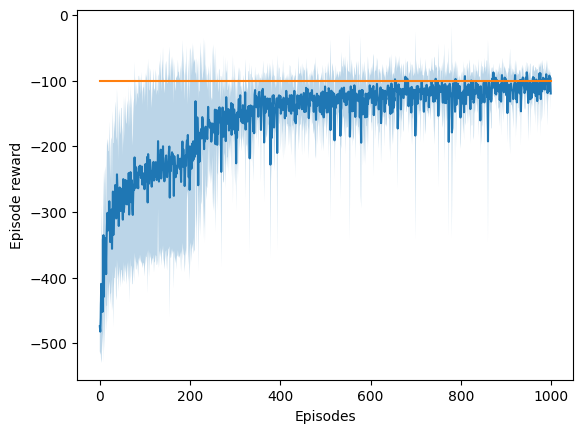

In [19]:
mean_score = np.mean(scores_runs,axis = 0)
se_score = np.std(scores_runs,axis = 0)
episode = np.arange(0,num_epsiodes)
max_line = -100* np.ones(num_epsiodes)
plt.figure()
plt.xlabel('Episodes')
plt.ylabel('Episode reward')
plt.plot(episode,mean_score)
plt.plot(episode, max_line)
plt.fill_between(episode, 
                 mean_score-se_score, 
                 mean_score+se_score, 
                 alpha = 0.3)
plt.show()

In [21]:
max_score = np.max(mean_score)
regret = np.sum(max_score - mean_score)/num_epsiodes
print(f'Regret = {regret}')

Regret = 70.5576


In [22]:

import pickle
with open('acrobot_reinforce_last.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(scores_runs, file) 
